In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

import os
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, accuracy_score, make_scorer

# carregando dataset

In [3]:
df = pd.read_csv('../Train_Test_Network.csv')
df = df.replace('-', None)
df.shape

(461043, 45)

# removendo colunas com NaN e colunas que dão spoiler das classes (ts, ip)

In [8]:
df = df.dropna(axis=1)

X = df.drop(['label', 'type', 'src_ip', 'dst_ip', 'ts'], axis=1)#.values
y = df['label'].values

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# mudando tipo das colunas e definindo função de métricas

In [10]:
# determine categorical and numerical features
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns

def classification_report_with_accuracy_score(y_true, y_pred):
    print (classification_report(y_true, y_pred) )# print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

# comitê

In [11]:
from sklearn.ensemble import VotingClassifier

est_AB = RandomForestClassifier(criterion= 'log_loss', 
                       max_depth= 8, 
                       max_features= 'log2', 
                       min_samples_split= 4, 
                       n_estimators= 300)

est_RF = tree.DecisionTreeClassifier(criterion='log_loss',
                                               min_samples_split=2,
                                               splitter='best')

est_MLP = MLPClassifier(activation='tanh',
                                  alpha=0.001,
                                  hidden_layer_sizes=(100, 100),
                                  learning_rate='adaptive',
                                  max_iter=200,
                                  solver='adam',
                                  verbose=True)

est_Ensemble = VotingClassifier(estimators=[('AB', est_AB), ('RF', est_RF), ('MLP', est_MLP)],
                        voting='soft')

In [12]:
enc = OrdinalEncoder()

ct = ColumnTransformer(
    [("text_preprocess", enc, categorical_ix),
     ('num_preprocess', MinMaxScaler(), numerical_ix)])

clf = make_pipeline(est_Ensemble)

X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)

scores = cross_val_score(
    clf, 
    X_train, 
    y_train, 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
    scoring=make_scorer(classification_report_with_accuracy_score), verbose=1)
scores

In [13]:
clf.fit(X_train, y_train)

Iteration 1, loss = 0.30743776
Iteration 2, loss = 0.22824350
Iteration 3, loss = 0.19223812
Iteration 4, loss = 0.17109320
Iteration 5, loss = 0.15832943
Iteration 6, loss = 0.15126205
Iteration 7, loss = 0.14723932
Iteration 8, loss = 0.14492918
Iteration 9, loss = 0.14248028
Iteration 10, loss = 0.13990827
Iteration 11, loss = 0.13748401
Iteration 12, loss = 0.13558243
Iteration 13, loss = 0.13331579
Iteration 14, loss = 0.13057849
Iteration 15, loss = 0.12899526
Iteration 16, loss = 0.12821707
Iteration 17, loss = 0.12729760
Iteration 18, loss = 0.12647812
Iteration 19, loss = 0.12615280
Iteration 20, loss = 0.12546846
Iteration 21, loss = 0.12524428
Iteration 22, loss = 0.12496866
Iteration 23, loss = 0.12448361
Iteration 24, loss = 0.12439990
Iteration 25, loss = 0.12407551
Iteration 26, loss = 0.12370588
Iteration 27, loss = 0.12339246
Iteration 28, loss = 0.12327186
Iteration 29, loss = 0.12322788
Iteration 30, loss = 0.12266058
Iteration 31, loss = 0.12283170
Iteration 32, los

Pipeline(steps=[('votingclassifier',
                 VotingClassifier(estimators=[('AB',
                                               RandomForestClassifier(criterion='log_loss',
                                                                      max_depth=8,
                                                                      max_features='log2',
                                                                      min_samples_split=4,
                                                                      n_estimators=300)),
                                              ('RF',
                                               DecisionTreeClassifier(criterion='log_loss')),
                                              ('MLP',
                                               MLPClassifier(activation='tanh',
                                                             alpha=0.001,
                                                             hidden_layer_sizes=(100,
                                                                                 100),
                                                             learning_rate='adaptive',
                                                             verbose=True))],
                                  voting='soft'))])

In [14]:
y_pred = clf.predict(X_test)

In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     60000
           1       0.99      0.99      0.99     32209

    accuracy                           0.99     92209
   macro avg       0.99      0.99      0.99     92209
weighted avg       0.99      0.99      0.99     92209



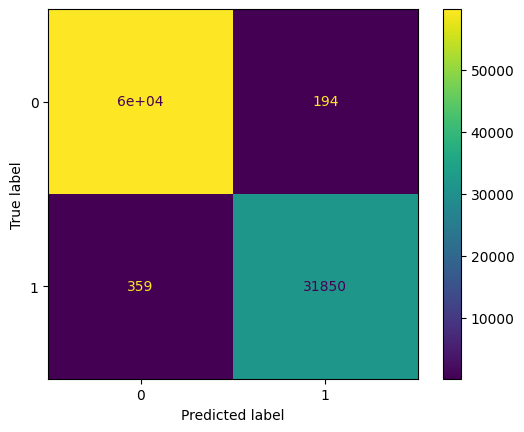

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=clf.classes_)
disp.plot()